# Urban Air Pollution Challenge


__Can you predict air quality in cities around the world using satellite data?__

For this challenge we’ll be digging deeper into Air quality data in several African cities, finding ways to track air quality and how it is changing, even in places without ground-based sensors. The collected weather data and daily observations are from the _Sentinel 5P satellite_ tracking various pollutants in the atmosphere. 

Our goal is to use the information from such data to predict _PM2.5_ particulate matter concentration (a common measure of air quality that normally requires ground-based sensors to measure) every day for each city. The data covers the last three months, spanning hundreds of cities across the globe.

_This is a Zindi data challenge, for more details check: [Urban Air Pollution challenge](https://zindi.africa/competitions/zindiweekendz-learning-urban-air-pollution-challenge)_


The objective of this challenge is to predict __PM2.5__ particulate matter concentration in the air __every day__ for __each city__. 
- PM2.5 refers to atmospheric particulate matter that have a diameter of __less than 2.5 micrometers__ 
- Is one of the most harmful air pollutants. 
- PM2.5 is a common measure of air quality that normally requires ground-based sensors to measure.

The data comes from three main sources:

1. __Ground-based air quality sensors__. These measure the __target__ variable (PM2.5 particle concentration). In addition to the `target` column (which is the daily mean concentration) there are also columns for `minimum` and `maximum` readings on that day, the `variance` of the readings and the total number (`count`) of sensor readings used to compute the target value. _This data is only provided for the train set_ - you must predict the target variable for the test set.

2. __The Global Forecast System (GFS)__ for _weather data_. `Humidity`, `temperature` and `wind speed`, which can be used as inputs for your model.

3. __The Sentinel 5P satellite__. This satellite monitors various _pollutants_ in the atmosphere. For each pollutant, we queried the `offline Level 3` (L3) datasets available in Google Earth Engine (you can read more about the individual products here: https://developers.google.com/earth-engine/datasets/catalog/sentinel-5p). For a given pollutant, for example NO2, we provide all data from the Sentinel 5P dataset for that pollutant. This includes the key measurements like `NO2_column_number_density` (a measure of NO2 concentration) as well as metadata like the `satellite altitude`. We recommend that you __focus on the key measurements__, either the `column_number_density` or the `tropospheric_X_column_number_density` (which measures density closer to Earth’s surface).
Unfortunately, this data is not 100% complete. Some locations have no sensor readings for a particular day, and so those rows have been excluded. There are also gaps in the input data, particularly the satellite data for CH4.



This data is not 100% complete. Some locations have no sensor readings for a particular day, and so those rows have been excluded. There are also gaps in the input data, particularly the satellite data for CH4.

## Upload the data

In [1]:
import sys
print(sys.executable)

/home/ilaria/Data Science/Bootcamp/.venv/bin/python


In [2]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.linear_model import LinearRegression

In [3]:
# Upload Train data
df_train=pd.read_csv('data/Train.csv')

# Upload Test data
df_test=pd.read_csv('data/Test.csv')

In [4]:
df_train.columns

Index(['Place_ID X Date', 'Date', 'Place_ID', 'target', 'target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle',
   

In [5]:
df_train.head(10)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,010Q650 X 2020-01-07,2020-01-07,010Q650,28.0,10.0,52.0,1053.22,94,14.600000,42.200001,...,30.605176,-62.134264,23.419991,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,010Q650 X 2020-01-08,2020-01-08,010Q650,21.0,6.0,51.0,1239.66,96,15.600000,47.100002,...,60.866484,-71.908414,32.348835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,010Q650 X 2020-01-09,2020-01-09,010Q650,18.0,6.0,28.0,307.93,93,18.600000,62.400002,...,59.674296,-60.765053,26.396956,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,010Q650 X 2020-01-10,2020-01-10,010Q650,21.0,15.0,33.0,305.92,95,11.800000,39.000000,...,37.176703,-73.812750,31.707143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,010Q650 X 2020-01-11,2020-01-11,010Q650,24.0,16.0,32.0,279.19,85,10.396144,33.100002,...,10.016394,-68.586306,28.090359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
# Y = df[]

## Data cleaning and feature engineering

In [7]:
# Check the number of nans for each column
missing = pd.DataFrame(df_train.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/df_train.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
L3_NO2_NO2_column_number_density,2189,7.16
L3_NO2_NO2_slant_column_number_density,2189,7.16
L3_NO2_absorbing_aerosol_index,2189,7.16
L3_NO2_cloud_fraction,2189,7.16
L3_NO2_sensor_altitude,2189,7.16
...,...,...
L3_CH4_aerosol_optical_depth,24765,81.05
L3_CH4_sensor_azimuth_angle,24765,81.05
L3_CH4_sensor_zenith_angle,24765,81.05
L3_CH4_solar_azimuth_angle,24765,81.05


In [25]:
cols = df_train.columns[df_train.isna().sum() > 20000].tolist()

In [26]:
df_train = df_train.drop(columns = cols)

df_train = df_train.reset_index(drop=True)

In [28]:
df_train = df_train.drop('Place_ID X Date', axis = 1)

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 74 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 30557 non-null  object 
 1   Place_ID                                             30557 non-null  object 
 2   target                                               30557 non-null  float64
 3   target_min                                           30557 non-null  float64
 4   target_max                                           30557 non-null  float64
 5   target_variance                                      30557 non-null  float64
 6   target_count                                         30557 non-null  int64  
 7   precipitable_water_entire_atmosphere                 30557 non-null  float64
 8   relative_humidity_2m_above_ground                    30557 non-nul

In [11]:
df_train.describe()

,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,...,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle
count,30557.000000,30557.000000,30557.000000,3.055700e+04,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,...,30360.000000,23320.000000,23320.000000,23320.000000,23249.000000,23320.000000,23320.000000,23320.000000,23320.000000,23320.000000
mean,61.148045,29.025866,117.992234,7.983756e+03,125.831135,15.302326,70.552747,0.006004,9.321342,0.416886,...,48.752878,0.000113,0.429221,0.000032,-1.944519,0.213883,-13.667626,35.590916,-123.697777,46.533951
std,46.861309,33.119775,100.417713,4.863090e+04,146.581856,10.688573,18.807884,0.003787,9.343226,2.707990,...,14.297861,0.000899,0.252026,0.000167,0.707915,0.157966,75.951317,18.955228,71.916036,14.594267
min,1.000000,1.000000,1.000000,0.000000e+00,2.000000,0.420044,5.128572,0.000139,-34.647879,-15.559646,...,8.251382,-0.038756,0.000000,-0.004309,-4.833706,0.000000,-111.997123,0.000000,-179.880630,0.000000
25%,25.000000,5.000000,60.000000,1.064920e+03,44.000000,7.666667,58.600002,0.003403,3.123071,-1.097864,...,38.368752,-0.000107,0.251275,-0.000043,-2.372976,0.076872,-97.650684,19.451524,-165.882624,36.693094
50%,50.000000,15.000000,91.000000,2.395350e+03,72.000000,12.200000,74.099998,0.004912,8.478424,0.222092,...,48.993025,0.000056,0.377935,0.000023,-1.963547,0.190333,-14.308518,37.918838,-156.637162,47.445010
75%,80.000000,44.000000,155.000000,5.882550e+03,150.000000,19.900000,85.450001,0.007562,16.201563,1.772925,...,59.321642,0.000280,0.552592,0.000097,-1.556129,0.344763,69.610002,52.270055,-118.453598,57.438181
max,815.000000,438.000000,999.000000,1.841490e+06,1552.000000,72.599998,100.000000,0.021615,37.437921,17.955124,...,87.491086,0.026994,2.184119,0.006988,3.736877,0.618176,80.544067,66.111289,179.776125,79.631711


In [12]:
df_train['Date'].nunique()

94

In [13]:
df_train.groupby("Place_ID")["Date"].agg(["min", "max"]).head()

,min,max
Place_ID,,
010Q650,2020-01-02,2020-04-04
05EC30X,2020-01-02,2020-04-04
0DPWHX8,2020-01-02,2020-04-04
0GBXTHY,2020-01-02,2020-04-04
0HYPV1N,2020-01-02,2020-04-04


This pipeline uses a custom transformer to fill missing values with the median calculated within each Place_ID group, then standardizes the features.

In [ ]:
target_vars = ['target', 'target_min', 'target_max', 'target_variance', 'target_count']
id_cols = ['Place_ID', 'Date']
num_cols = [col for col in df_train.columns if col not in target_vars + id_cols and pd.api.types.is_numeric_dtype(df_train[col])]

In [ ]:
# define class to impute with mean by Place_ID
from sklearn.base import BaseEstimator, TransformerMixin

class GroupByPlaceIDImputer(BaseEstimator, TransformerMixin):
    def __init__(self, place_id='Place_ID', strategy='mean'):
        self.place_id = place_id
        self.strategy = strategy
    def fit(self, X, y=None):
        self.group_mean_ = X.groupby(self.place_id).transform(self.strategy)
        return self
    def transform(self, X):
        X_filled = X.copy()
        for col in X.columns:
            if col != self.place_id:
                mask = X_filled[col].isna()
                X_filled.loc[mask, col] = self.group_mean_.loc[mask, col]
        return X_filled.drop(columns=[self.place_id])

In [15]:
# X = df_train.drop(['target', 'target_min', 'target_max', 'target_variance', 'target_count'], axis=1)

In [43]:
df_train.shape

(30557, 74)

In [41]:
pipeline = Pipeline([
    ('groupby_imputer', GroupByPlaceIDImputer(place_id='Place_ID', strategy='mean')),
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
    ('num', pipeline, ['Place_ID'] + num_cols),
], remainder='passthrough')

In [45]:
df_preprocessed = preprocessor.fit_transform(df_train)
df_preprocessed = pd.DataFrame(df_preprocessed, columns=num_cols + ['Date'] + target_vars)
df_preprocessed['Place_ID'] = df_train['Place_ID'].values

### EDA

In [ ]:
print(df_train.columns)

Index(['Place_ID X Date', 'Date', 'Place_ID', 'target', 'target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle',
   

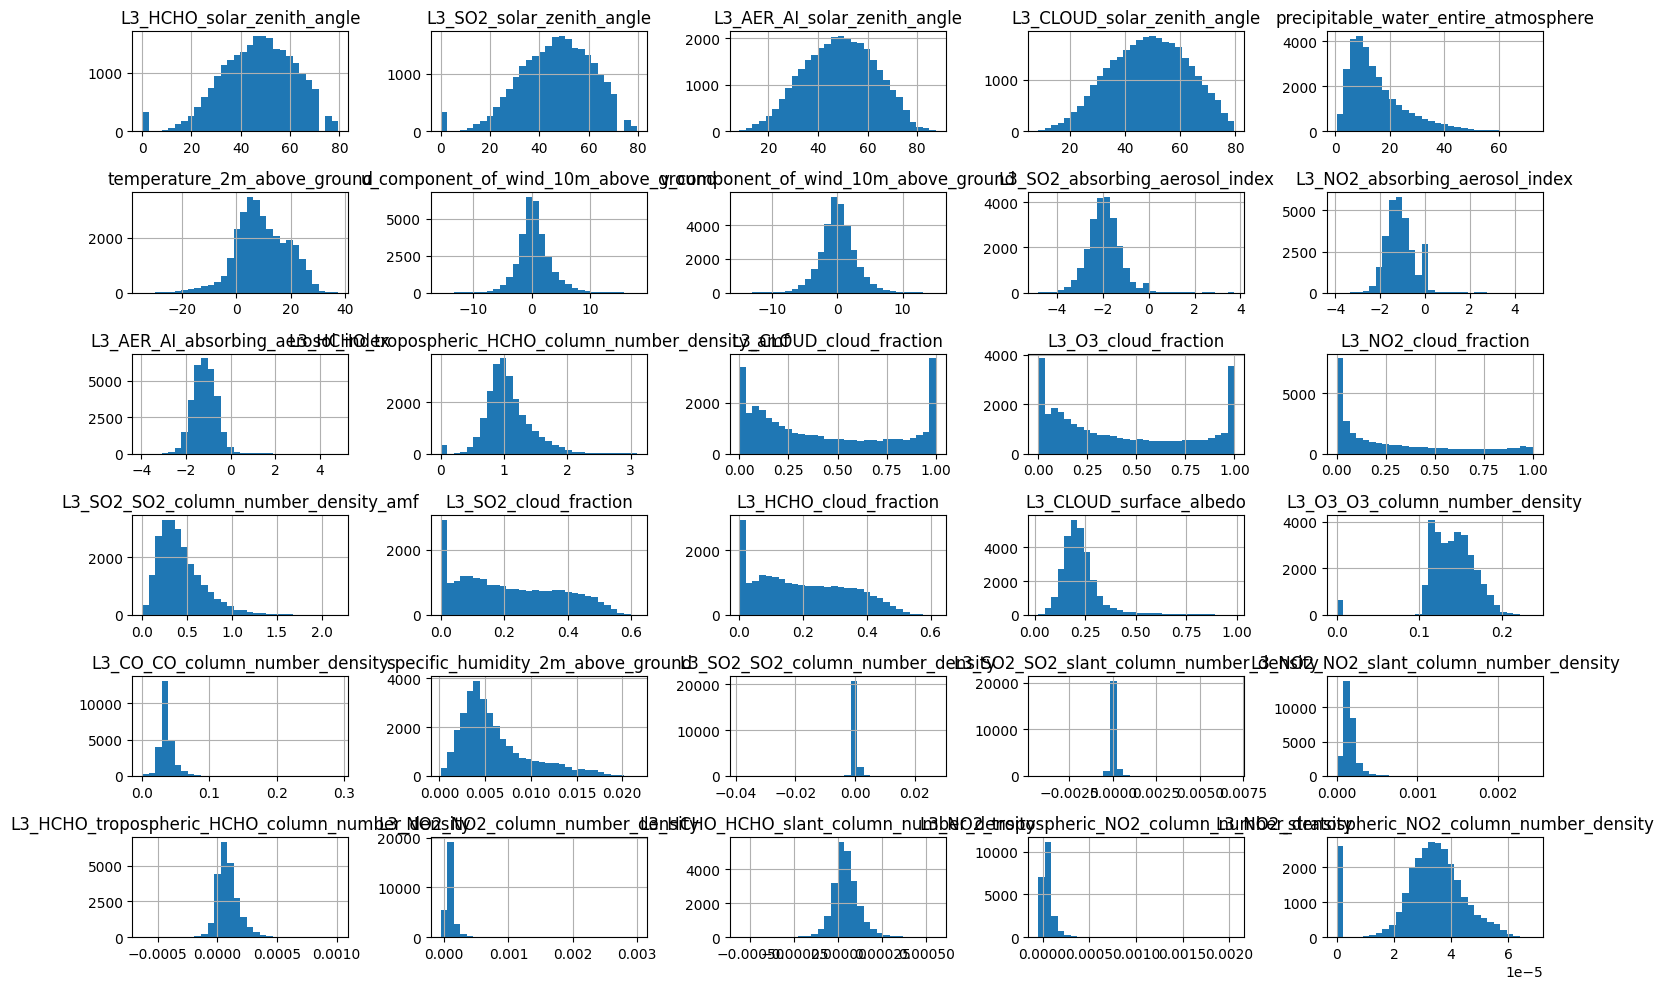

In [ ]:
variances = df_train[num_cols].var()
top_vars = variances.sort_values(ascending=False).tail(30).index
df_train[top_vars].hist(bins=30, figsize=(15,10))
plt.tight_layout()
plt.show()

In [ ]:
# X = 

## Splitting data for testing 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
X_train.info()

In [ ]:
# fillna with mean.. 
# X_train[""] = X_train[""].fillna()

## Trainining the model

In [ ]:
## in order to exemplify how the predict will work.. we will save the y_train
X_test.to_csv("data/X_test.csv")
y_test.to_csv("data/y_test.csv")

In [ ]:
#training the model
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
y_train_pred = reg.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
print(mse)

<Axes: >

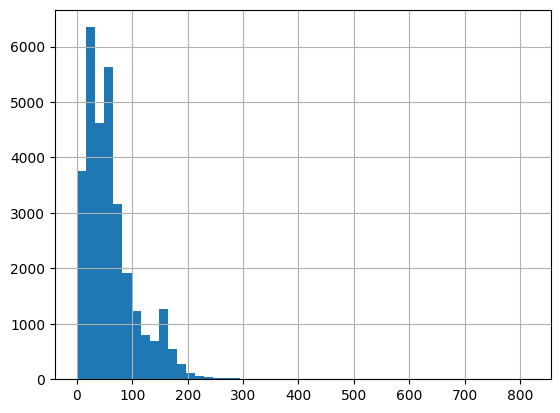

In [ ]:
df_train['target'].hist(bins = 50)